Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/15, Loss: 4.7372, Training Time: 4.76s
Epoch 2/15, Loss: 1.9082, Training Time: 2.74s
Epoch 3/15, Loss: 1.5155, Training Time: 2.17s
Epoch 4/15, Loss: 1.2689, Training Time: 2.10s
Epoch 5/15, Loss: 1.0994, Training Time: 2.18s
Epoch 6/15, Loss: 0.9829, Training Time: 2.25s
Epoch 7/15, Loss: 0.8332, Training Time: 3.04s
Epoch 8/15, Loss: 0.7482, Training Time: 2.47s
Epoch 9/15, Loss: 0.6119, Training Time: 2.12s
Epoch 10/15, Loss: 0.5266, Training Time: 2.13s
Epoch 11/15, Loss: 0.4130, Training Time: 2.14s
Epoch 12/15, Loss: 0.3467, Training Time: 2.66s
Epoch 13/15, Loss: 0.2918, Training Time: 3.33s
Epoch 14/15, Loss: 0.2537, Training Time: 2.19s
Epoch 15/15, Loss: 0.2300, Training Time: 2.15s
Test Loss: 0.0018
Inference Time: 0.20s
Train Time: 2.15s

=== Test Results ===
MSE   = 0.0014
RMSE  = 0.0373
MAE   = 0.0285
MAPE  = 0.0481
R²    = 0.9709


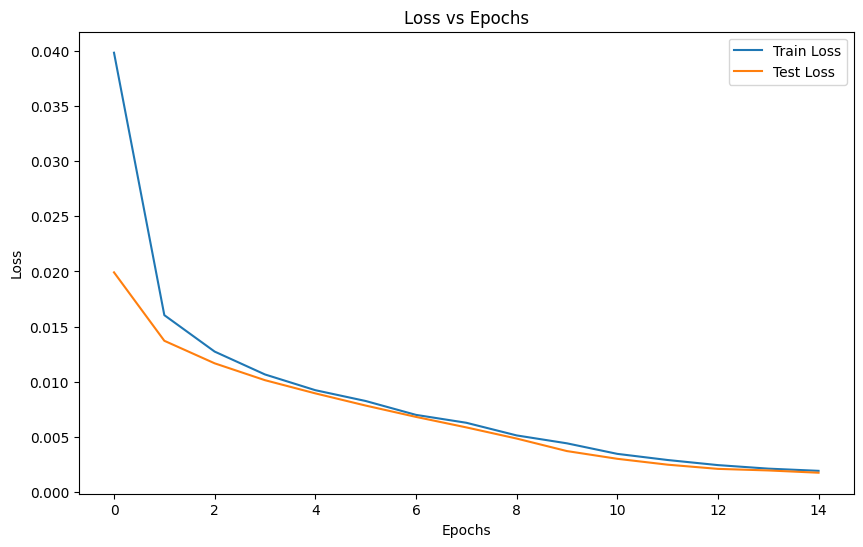

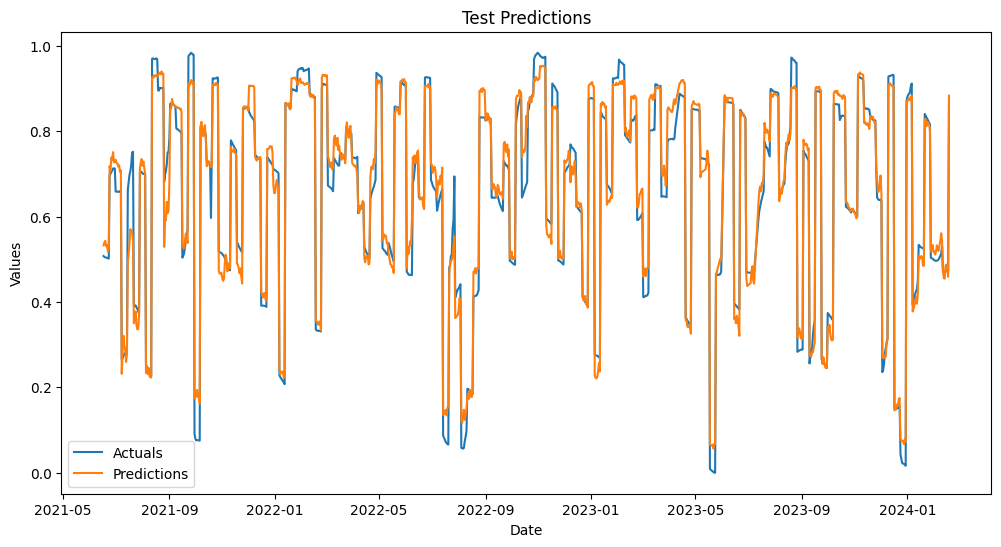

Future Predictions (console output):
Gelecek Tahminler ve Tarihler:
Tarih: 2024-02-19 00:00:00, Tahmin: 0.8735962
Tarih: 2024-02-20 00:00:00, Tahmin: 0.7872291
Tarih: 2024-02-21 00:00:00, Tahmin: 0.7858132
Tarih: 2024-02-22 00:00:00, Tahmin: 0.7862149
Tarih: 2024-02-23 00:00:00, Tahmin: 0.7900053
Tarih: 2024-02-24 00:00:00, Tahmin: 0.7953051
Tarih: 2024-02-25 00:00:00, Tahmin: 0.8011392


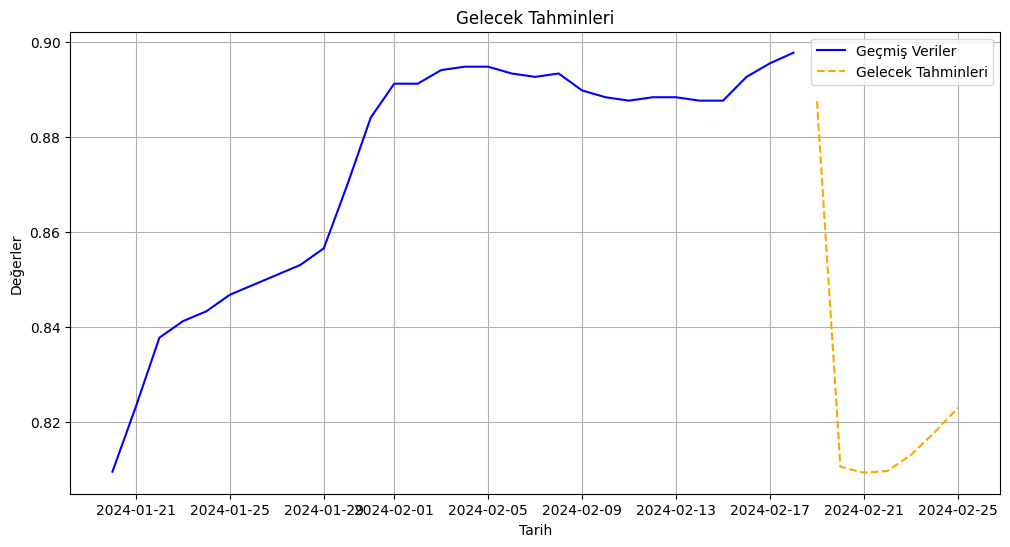

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from math import sqrt
from google.colab import drive
import random


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)



drive.mount('/content/drive')


df = pd.read_json("/content/drive/MyDrive/Processed_Baraj_Data_Fixed_Deneme.json")

# Tarih sütununu datetime formatına çevir
df['Tarih'] = pd.to_datetime(df['Tarih'])
df['Yil'] = df['Tarih'].dt.year
df['Ay'] = df['Tarih'].dt.month
df['Gun'] = df['Tarih'].dt.day

# Test verisi tarihleri
original_dates = df['Tarih']

# Tarih sütununu çıkart
df = df.drop(columns=['Tarih'])

# Mevsim sütunu ekle
df['mevsim'] = df['Ay'].apply(lambda x: 1 if x in [12, 1, 2] else (2 if x in [3, 4, 5] else (3 if x in [6, 7, 8] else 4)))

# Toplam yağış sütunu ekle
rain_columns = [col for col in df.columns if '_Yagis' in col]
df['toplam_yağış'] = df[rain_columns].sum(axis=1)

# Kümülatif yağış ve gecikmeli özellikler ekle
df['kümülatif_yağış_7gün'] = df['toplam_yağış'].rolling(window=7, min_periods=1).sum()
df['yağış_lag_1'] = df['toplam_yağış'].shift(1)
df['yağış_lag_2'] = df['toplam_yağış'].shift(2)

# Eksik değerleri doldur
df.fillna(0, inplace=True)

# Hedef sütun
target_column = "Omerli_Doluluk"
input_features = df.drop(columns=[target_column]).values
target_values = df[target_column].values

# Veriyi normalize et
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(input_features)
scaled_target = scaler.fit_transform(target_values.reshape(-1, 1))

# Veri penceresi oluşturma fonksiyonu
def create_sequences(data, target, input_window, output_window):
    X, y = [], []
    for i in range(len(data) - input_window - output_window):
        X.append(data[i:i+input_window])
        y.append(target[i+input_window:i+input_window+output_window])
    return np.array(X), np.array(y)

# Pencere boyutları
input_window = 30
output_window = 7
X, y = create_sequences(scaled_features, scaled_target, input_window, output_window)

# Eğitim ve test setlerini ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Torch tensörlerine çevir
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
y_train = y_train.squeeze(-1)
y_test = y_test.squeeze(-1)

# DataLoader
batch_size = 32
train_loader = DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Model tanımı
class InformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, embed_dim=64, num_heads=8, dropout=0.1):
        super(InformerModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.input_projection = nn.Linear(input_dim, embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.dropout_layer = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.output_projection = nn.Sequential(
    nn.Linear(embed_dim, output_dim),
    nn.Sigmoid()
)


    def forward(self, x):
        x = self.input_projection(x)
        attn_output, _ = self.attention(x, x, x)
        x = self.layer_norm(x + attn_output)
        ff_output = self.feedforward(x)
        x = self.layer_norm(x + self.dropout_layer(ff_output))
        output = self.output_projection(x[:, -1, :])
        return output.unsqueeze(-1)

# Model parametreleri
input_dim = X_train.shape[2]
output_dim = y_train.shape[1]
embed_dim = 64
num_heads = 8
assert embed_dim % num_heads == 0,"embed_dim must be divisible by num_heads"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InformerModel(input_dim=input_dim, output_dim=output_dim, embed_dim=embed_dim, num_heads=num_heads).to(device)

# Eğitim döngüsü
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 15
train_losses, test_losses = [], []
train_times, inference_times = [], []

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(-1), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_time = time.time() - start_time
    train_times.append(train_time)
    train_losses.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Training Time: {train_time:.2f}s")

    model.eval()
    test_loss = 0
    predictions, actuals = [], []
    with torch.no_grad():
        start_inference_time = time.time()
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze(-1)
            test_loss += criterion(outputs, y_batch).item()
            predictions.append(outputs.cpu().numpy())
            actuals.append(y_batch.cpu().numpy())
        inference_time = time.time() - start_inference_time
        inference_times.append(inference_time)
    test_losses.append(test_loss / len(test_loader))

print(f"Test Loss: {test_losses[-1]:.4f}")
print(f"Inference Time: {inference_times[-1]:.2f}s")
print(f"Train Time: {train_times[-1]:.2f}s")

# Metrik hesaplama
actuals = np.concatenate(actuals, axis=0).flatten()
predictions = np.concatenate(predictions, axis=0).flatten()

actuals_real= scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()
predictions_real = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

mse = mean_squared_error(actuals_real, predictions_real)
mape = mean_absolute_percentage_error(actuals_real, predictions_real)
mae = mean_absolute_error(actuals_real, predictions_real)
rmse = sqrt(mse)
r2 = r2_score(actuals_real, predictions_real)

print("\n=== Test Results ===")
print(f"MSE   = {mse:.4f}")
print(f"RMSE  = {rmse:.4f}")
print(f"MAE   = {mae:.4f}")
print(f"MAPE  = {mape:.4f}")
print(f"R²    = {r2:.4f}")

# Eğitim ve test loss grafikleri
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label="Train Loss")
plt.plot(range(epochs), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.show()

# Test tahminleri grafiği
relevant_dates = original_dates[-len(y_test):]
plt.figure(figsize=(12, 6))
plt.plot(relevant_dates, actuals[:len(relevant_dates)], label="Actuals")
plt.plot(relevant_dates, predictions[:len(relevant_dates)], label="Predictions")
plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Test Predictions")
plt.legend()
plt.show()

print("Future Predictions (console output):")

# Gelecek tarihleri oluştur
future_dates = pd.date_range(original_dates.iloc[-1], periods=output_window + 1, freq='D')[1:]  # Tahmin aralığı

# Gelecek tahminlerini tutacak liste
future_predictions = []
model.eval()
with torch.no_grad():
    input_sequence = scaled_features[-input_window:].reshape(1, input_window, -1)  # Son pencere
    for i in range(len(future_dates)):
        input_sequence = torch.tensor(input_sequence, dtype=torch.float32).to(device)
        future_pred = model(input_sequence).cpu().numpy()
        future_predictions.append(future_pred.flatten()[0])  # Sadece ilk değeri al

        # Pencereyi güncelle: Yeni tahmini ekle ve en eski değeri çıkar
        input_sequence = np.roll(input_sequence, -1, axis=1)
        input_sequence[0, -1, :] = future_pred.flatten()[i]  # Yeni tahmini ekle

# Gelecek tarih ve tahminlerini yazdırma
print("Gelecek Tahminler ve Tarihler:")
for date, prediction in zip(future_dates, future_predictions):
    print(f"Tarih: {date}, Tahmin: {prediction:.7f}")

# Gelecek tahmin grafiği için gelecekteki tahmin değerlerini normalize edilmişten çıkar
future_predictions_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Gelecek tahmin grafiği
plt.figure(figsize=(12, 6))

# Geçmiş veri çizimi (örnek olarak son 30 gün)
plt.plot(
    original_dates[-30:],
    scaler.inverse_transform(target_values[-30:].reshape(-1, 1)),
    label="Geçmiş Veriler",
    color="blue"
)

# Gelecek tahmin çizimi
plt.plot(
    future_dates,
    future_predictions_actual,
    label="Gelecek Tahminleri",
    linestyle="--",
    color="orange"
)

plt.xlabel("Tarih")
plt.ylabel("Değerler")
plt.title("Gelecek Tahminleri")
plt.legend()
plt.grid()
plt.show()